# Outcome Analysis for Parcel-Level CF Annotations

In [1]:
import geopandas as gpd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
import seaborn as sns
from tqdm import tqdm
from shapely import wkt
import shapely

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings("ignore")

tqdm.pandas()

In [2]:
# Load functions 
%run ADU_permit_matching-polygon-pipeline.ipynb import compare_building_footprint

In [3]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

In [4]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

# * San Jose AANC permit data
permits = pd.read_csv(os.path.join(OAK_FP, 'outputs/Permit-Matching/outputs/all_permits.csv'))
permits['geometry_permit'] = gpd.GeoSeries.from_wkt(permits['geometry_permit'])
permits_2015_20 = permits.loc[
    permits['issue_year'].isin([2015, 2016, 2017, 2018, 2019, 2020])].copy()

In [5]:
# Ground truth small building consutrction cases
# Batch 1
test_cases = {
    'true(new)': [
        '45120021', '44732030', '43933037', '44626011', '46432056', '43428123', 
        '27453041', '26462005', '30341002', '30334023', '47701055', '48125057',
        '29928063', '37317034', '27726026', '30330004', '30327016', '24960051', 
        '24529043', '46227003', '26123040', '41934030', '44228010', '49704006', 
        '49724012', '49902047', '49927002', '59949012', '65219015', '01511081', 
        '48611010', '48612015', '48635017', '48804008', '48804026', '49109059',
        '49119021', '49407021', '49709005', '49902084', '49916019', '56911050', 
        '56938060', '58629019', '59205028', '64920009', '65424001', '65937019', 
        '67032055', '67622042', '67849070', '68433070', '69205043', '69210133', 
        '69226014', '70617022', '68701028', '70101032', '68452040', '67018013', 
        '69501022', '67646016', '68922029', '26449031',
        '46237003', # no CF label
        '48605010', 
        '47701055',
        '69501022'
    ],
    'true(replace)': [
        '43406087', '42933015', '27409002', '26435035', '24509006', '26117066', 
        '24902060', '48144016', '42914030', '48419045', '49461011', '59214041',
        '67646033', '67832020', '47736020', '48446044', '49141060', '68918083', 
        '67303059', '67008008', '24928012', '47745061', '48129033', '48425023',
        '42947023', # CF labels same building but clearly roof construction
        '24927036', '24953062',
        '46740005', # roof change, no CF labels
        '43909051', # roof change, CF same buildings
        '47703128',
        '68432012',
        '24919080'
    ],
    'true(two)': [
        '26462005', '49902047', '24902060'],
    'false': [
        '44708058', '44629050', '43917076', '43409088', '42929009', '44626008', 
        '41944094', '42926032', '43915071', '42903018', '46714029', '44706008',
        '43920020', '42940022', '44627033', '46705041', '46707017', '43946024', 
        '43429050', '42108046', '42923006', '43903050', '42117003', '42950063',
        '43422021', '41917050', '42916008', '43424064', '42950046', '44638005', 
        '44709053', '45515080', '44232048', '43925046', '43910021', 
        '42908005', '44627041', '42906013', '43914059', '42924011', 
        '42114072', '27445085', '40304054', '24958007',
        '25404032', #  relabeled image doesn't have any small building
        '27423086', '27437020', '27438048', '28213044', '28214011',
        '43412093', '44245040', '46738010', '01506001', 
        '47229033', '47229085', '48426033', '48816030', 
        # this example indicates that that small building is not a dwelling unit
        '56922048', # this is a hard case but it seems the small builds were just moved around
        '58923068', '59108040', '64906009', '65438025', '68945071', '42935022', 
        '43917140', # parcel was revised with no buildings but there should be (original annotation was correct)
        '46207052', '65215028', # this parcel was revised but had a bug that was resolved in original batch
        '69525051', '67310023', '67845058', 
        '46705073',
        '48617007',
        '68452041',
        '68517057',
        '68955095',
        '48116063',
        '48128059',
        '24915056',
        '24916004',
        '24929031',
        '24938019',
        '25411059',
        '26421037',
        '27412054',
        '28826037',
        '40358067',
        '42902039',
        '43412027',
        '44627024',
        '44704108',
        '46737004', 
        '43410074', 
        '47228068', '26442083', '47222045', '48611023', '49131053', '49414019', '49724060'
    ]
}

In [6]:
def extract_CF_poly(CF_FP, OAK_FP, params):
    
    if params['verbose']:
        print('\n[PIPELINE] Extracting CF polygons and determining annotated parcels')
    
    # Load batch data and batch query
    # * Submitted parcels
    submitted_parcels = glob.glob(
        os.path.join(CF_FP, 'images', 'batch{}'.format(params['batch']), 'images', '*.png'))
    
    # * Annotated parcels
    with open(os.path.join(
        CF_FP, 'exports', 'Batch{}_{}'.format(params['batch'], params['completion']), 'apn.txt'), 'r') as f:
        annotated_parcels = f.readlines()[0]
        annotated_parcels = annotated_parcels.split(',')
        
    # Subset parcels
    if params['subset'] == 100:
        subset_parcels = annotated_parcels
    else:
        # Subset parcels
        subset_parcels = np.random.choice(
            annotated_parcels, size=int(len(annotated_parcels) * params['subset'] / 100), replace=False)        

    # Generate shp of annotated area
    annotated_parcels_shp = sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'].isin(annotated_parcels)].copy()
    
    # Load extracted polygons
    sbuild = pd.read_csv(
        os.path.join(OAK_FP, 'CloudFactory/results/Batch{}_{}/processed_buildings.csv'.format(
            params['batch'], params['completion'])), 
        dtype={'apn': str})
    sbuild.rename(columns={'apn': 'APN'}, inplace=True)
    sbuild.reset_index(inplace=True, drop=False)
    sbuild.rename(columns={'index': 'building_index'}, inplace=True)
    assert len(sbuild['building_index'].unique()) == len(sbuild)
    
    # Subset to annotated (possibly subsetted) parcels
    sbuild = sbuild.loc[sbuild['APN'].isin(subset_parcels)]
    
    # * Parcels with small buildings in either year
    smallbuild_parcels = sbuild['APN'].unique()
    
    # Impose minimum size for small buildings
    # * Compute 2016 and 2020 areas
    wgs84 = pyproj.CRS('EPSG:26910')
    utm = pyproj.CRS('EPSG:4326')
    project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform

    sbuild['2016_min_area'] = sbuild['2016'].apply(
        lambda geom: 0 if pd.isnull(geom) else shapely.ops.transform(project, wkt.loads(geom)).area)
    sbuild['2020_min_area'] = sbuild['2020'].apply(
        lambda geom: 0 if pd.isnull(geom) else shapely.ops.transform(project, wkt.loads(geom)).area)

    n_builds = len(sbuild)
    sbuild = sbuild.loc[(sbuild['2016_min_area'] >= params['min_sqft']) | (sbuild['2020_min_area'] >= params['min_sqft'])]

    if params['verbose']:
        print('[INFO] Number of unique buildings: {}'.format(len(sbuild)))
        print('[INFO] Dropping {} small buildings that do not meet the minimum area threshold.'.format(
            n_builds - len(sbuild)))
    sbuild.drop(['2016_min_area', '2020_min_area'], axis=1, inplace=True)
    
    # Make gdf for each year
    sbuild16 = sbuild[['building_index', 'APN', '2016']].copy()
    sbuild16 = sbuild16.loc[~sbuild16['2016'].isna()]
    sbuild16['2016'] = sbuild16['2016'].apply(wkt.loads)
    sbuild16 = gpd.GeoDataFrame(sbuild16, geometry='2016', crs='EPSG:4326')

    sbuild20 = sbuild.copy()
    sbuild20.drop('2016', axis=1, inplace=True)
    sbuild20 = sbuild20.loc[~sbuild20['2020'].isna()]
    sbuild20['2020'] = sbuild20['2020'].apply(wkt.loads)
    sbuild20 = gpd.GeoDataFrame(sbuild20, geometry='2020', crs='EPSG:4326')
    
    if params['verbose']:
        print('[INFO] Annotated {} parcels out of {} submitted parcels for batch {} at {}% completion'.format(
            len(annotated_parcels), len(submitted_parcels), params['batch'], 
            int(len(annotated_parcels) / len(submitted_parcels) * 100)))
        print('[INFO] Using {} subsetted parcels out of {} annotated parcels'.format(
            len(subset_parcels), len(annotated_parcels)))
    
    if not os.path.exists(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']))):
        os.makedirs(os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion'])))

    # Generate dataframe of small building counts per parcel and CF area coverage
    parcel_density = sbuild.notna().groupby(sbuild['APN'])[['2016', '2020']].sum().reset_index()
    parcel_density = pd.DataFrame({'APN': subset_parcels}).merge(
            parcel_density, how='left', validate='one_to_one')

    parcel_density.fillna(0, inplace=True)
    
    if params['verbose']:
        print('[INFO] Parcel likelihood of having an ADU in 2020: {}%'.format(
            round((parcel_density['2020'] > 0).mean() * 100, 1)
        ))
    
    if params['subset'] == 100:
        parcel_density.to_csv(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
                         'parcel_density-min{}.csv'.format(int(params['min_sqft']))), 
            index=False)

        CF_area_coverage = sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'].isin(subset_parcels)]
        CF_area_coverage.to_file(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
                         'CF_area_coverage'))
    
    if params['verbose']:
        print('[INFO] {} small buildings found in 2016; {} small buildings found in 2020'.format(
            int(parcel_density['2016'].sum()), int(parcel_density['2020'].sum())))

    return sbuild20, smallbuild_parcels

In [7]:
def identify_construction_events(sbuild20, smallbuild_parcels, test_cases, 
                                OUTPUT_FP, params):
    if params['verbose']:
        print('\n[PIPELINE] Detecting construction events')
    
    # Cloud Factory detection
    sbuild_2020_compared = sbuild20.copy()

    sbuild_2020_compared['area'] = sbuild_2020_compared.to_crs('EPSG:26910').geometry.area
    sbuild_2020_compared['year'] = '2020'

    # Construction event if exact_match == 0
    sbuild_2020_compared['expansion_2016_flag_CF'] = 1 - sbuild_2020_compared['exact_match']

    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared['expansion_2016_flag_CF']    
    sbuild_2020_compared['expansion_2016_flag'] = sbuild_2020_compared['expansion_2016_flag'].astype(bool)

    # Limit to ground truth cases
    if params['limit_to_GT']:
        if params['verbose']:
            print('[INFO] Number of predicted construction events: {}'.format(
            sbuild_2020_compared['expansion_2016_flag'].sum()))

        # Drop false positives
        # Note: False cases have NO small building construction events. True parcels can have
        # false events as there can be multiple small buildings in a parcel
        sbuild_2020_compared.loc[
            sbuild_2020_compared['APN'].isin(test_cases['false']), ['expansion_2016_flag']] = False 
        
        if params['verbose']:
            print('[INFO] Number of construction events after dropping FPs: {}'.format(
            sbuild_2020_compared['expansion_2016_flag'].sum()))

        # Note that we can't add false negatives because there can be multiple buildings
        # at the parcel level. 
        
        # HANDLE FN
        build_index = []
        drop_build_index = []
        true_building = test_cases['true(new)']+test_cases['true(replace)']
        for apn in true_building:
            subset = sbuild_2020_compared[sbuild_2020_compared['APN'] == apn]
            if subset.empty:
                max_idx = max(sbuild_2020_compared['building_index'])+1
                sbuild_2020_compared.loc[max_idx] = [max_idx, apn, np.nan, np.nan, np.nan, 2020, np.nan, True]
            else:
                if subset['expansion_2016_flag'].sum() == 0:
                    build_index.append(subset['building_index'].tolist()[0])
                elif subset['expansion_2016_flag'].sum() > 1:
                    N_events = subset['expansion_2016_flag'].sum()
                    drop_build_index.append(subset['building_index'].tolist()[0:(N_events - 1)])
                    
        sbuild_2020_compared.loc[
                    sbuild_2020_compared['building_index'].isin(build_index), ['expansion_2016_flag']] = True 
        sbuild_2020_compared.loc[
                    sbuild_2020_compared['building_index'].isin(drop_build_index), ['expansion_2016_flag']] = False 
        
        # Handle FNs with multiple (2) constructions
        build_index = []
        true_building = test_cases['true(two)']
        for apn in true_building:
            subset = sbuild_2020_compared[sbuild_2020_compared['APN'] == apn]
            if subset.empty:
                for i in range(2):
                    max_idx = max(sbuild_2020_compared['building_index'])+1
                    sbuild_2020_compared.loc[max_idx] = [max_idx, apn, np.nan, np.nan, np.nan, 2020, np.nan, True]
            else:
                if subset['expansion_2016_flag'].sum() < 2 and len(subset) > 1:
                    build_index.append([idx for idx in subset['building_index'].tolist()[:2]])
                elif subset['expansion_2016_flag'].sum() < 2 and len(subset) == 1:
                    build_index.append(subset['building_index'].tolist()[0])
                    max_idx = max(sbuild_2020_compared['building_index'])+1
                    sbuild_2020_compared.loc[max_idx] = [max_idx, apn, np.nan, np.nan, np.nan, 2020, np.nan, True]

        sbuild_2020_compared.loc[
                    sbuild_2020_compared['building_index'].isin(build_index), ['expansion_2016_flag']] = True 
        
    if params['verbose']:
        print('[INFO] We have {} small building annotations for 2020; and '
              'identify {} of these to be built after 2016'.format(
              len(sbuild_2020_compared), sbuild_2020_compared['expansion_2016_flag'].sum()))

    # Only save if we're not subsetting
    if params['subset'] == 100:
        sbuild_2020_compared[['APN', 'area', 'year', 'expansion_2016_flag']].to_csv(os.path.join(
            OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
            'sbuild_2020_compared-{}-min{}-GT{}.csv'.format(
                params['construction_detection'], int(params['min_sqft']), 
                1 if params['limit_to_GT'] else 0)), index=False)

        sbuild_2020_compared.to_file(os.path.join(
            OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
            'sbuild_2020_compared-{}-min{}-GT{}'.format(
                params['construction_detection'], int(params['min_sqft']), 
                1 if params['limit_to_GT'] else 0)), index=False)

    return sbuild_2020_compared

In [8]:
def ground_truth_construction_events(sbuild_2020_compared, test_cases, print_review=True):
    if params['verbose']:
        print('\n[PIPELINE] Checking ground truth construction events')

        print('[INFO] We find {} construction events'.format(sbuild_2020_compared['expansion_2016_flag'].sum()))

    # These checks ensure that at least one small building in the parcel is marked for a
    # construction event. 
    new_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(new)'])].copy()
    new_add = new_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
    new_add['expansion'] = new_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

    if params['verbose']:
        print('[INFO] True (new) additions: {}/{} out of {} cases'.format(
            new_add['expansion'].sum(), len(new_add), len(test_cases['true(new)'])))

    replace_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(replace)'])].copy()
    replace_add = replace_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
    replace_add['expansion'] = replace_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

    if params['verbose']:
        print('[INFO] True (replace) additions: {}/{} out of {} cases'.format(
            replace_add['expansion'].sum(), len(replace_add), len(test_cases['true(replace)'])))
        
    two_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['true(two)'])].copy()
    two_add = two_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
    two_add['expansion'] = two_add['expansion_2016_flag']
    
    if params['verbose']:
        print('[INFO] True (two) additions: {} out of {} cases'.format(
            two_add['expansion'].sum(), 2 * len(test_cases['true(two)'])))

    # This check ensures that no small building in these parcels is marked for a construction event. 
    false_add = sbuild_2020_compared.loc[sbuild_2020_compared['APN'].isin(test_cases['false'])].copy()
    false_add = false_add.groupby('APN')['expansion_2016_flag'].sum().reset_index()
    false_add['expansion'] = false_add['expansion_2016_flag'].apply(lambda x: min(x, 1))

    if params['verbose']:
        print('[INFO] False additions: {}/{} out of {} cases'.format(
            false_add['expansion'].sum(), len(false_add), len(test_cases['false'])))

    # Check all construction cases
    ground_truth_cases = test_cases['true(new)'] + test_cases['true(replace)'] + test_cases['false']
    sbuild_2020_compared = sbuild_2020_compared[['APN', 'area', 'year', 'expansion_2016_flag']]
    review = sbuild_2020_compared.loc[
        (sbuild_2020_compared['expansion_2016_flag'] == True) & ~(sbuild_2020_compared['APN'].isin(ground_truth_cases))]
    
    if params['verbose']:
        print('[INFO] {} events are pending revision'.format(
            sbuild_2020_compared['expansion_2016_flag'].sum() - new_add['expansion_2016_flag'].sum() - replace_add['expansion_2016_flag'].sum() - false_add['expansion_2016_flag'].sum()))
        if print_review:
            print(review.to_string())

In [9]:
def permit_match(OUTPUT_FP, permits_2015_20, sbuild_2020_compared, params):
    """
    Counts the number of newly constructed small buildings and the number of AANC permits issue
    during 2015-20 to determine what proportion are permitted vs unpermitted. 
    """
    if params['verbose']:
        print('\n[PIPELINE] Performing permit-matching using parcel APNs')
    
    # Get number of 2015-20 AANC permits per parcel
    parcel_permit_counts = permits_2015_20.copy()
    parcel_permit_counts = parcel_permit_counts.groupby('APN_parcel')['OBJECTID_left'].count().reset_index()
    parcel_permit_counts.rename(
        columns={'APN_parcel': 'APN', 'OBJECTID_left': 'pcount_2015_20'}, inplace=True)
    
    # Get new small building counts for each parcel
    new_sbuild_2020 = sbuild_2020_compared.loc[sbuild_2020_compared['expansion_2016_flag'] == True].copy()
    new_sbuild_2020 = new_sbuild_2020.groupby('APN')['expansion_2016_flag'].count().reset_index()
    new_sbuild_2020.rename(columns={'expansion_2016_flag': 'count_new_sbuild'}, inplace=True)
    
    # Merge permit and small building data
    new_sbuild_2020 = pd.merge(
        new_sbuild_2020, parcel_permit_counts[['APN', 'pcount_2015_20']], on='APN', 
        how='left', validate='one_to_one')

    # Fill parcel columns with zeros
    new_sbuild_2020[['pcount_2015_20']] = new_sbuild_2020[['pcount_2015_20']].fillna(value=0)

    # Compute unpermitted and permitted new small buildings at the parcel level
    new_sbuild_2020['count_new_sbuild_permitted'] = new_sbuild_2020.apply(
        lambda row: min(row['count_new_sbuild'], row['pcount_2015_20']), axis=1)
    new_sbuild_2020['count_new_sbuild_unpermitted'] = new_sbuild_2020[
        'count_new_sbuild'] - new_sbuild_2020['count_new_sbuild_permitted']

    assert new_sbuild_2020['count_new_sbuild_unpermitted'].sum() + new_sbuild_2020[
        'count_new_sbuild_permitted'].sum() == new_sbuild_2020['count_new_sbuild'].sum()
    
    if params['subset'] == 100:
        new_sbuild_2020.to_csv(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']),
                         'permit-matching-apns-{}-min{}-GT{}.csv'.format(
                             params['construction_detection'], int(params['min_sqft']), 
                             1 if params['limit_to_GT'] else 0)),
            index=False)
        
    # Print stats
    if params['verbose']:
        print('[INFO] Permitted small building constructions: {}'.format(
            new_sbuild_2020['count_new_sbuild_permitted'].sum() ))
        print('[INFO] Unpermitted small building constructions: {}'.format(
            new_sbuild_2020['count_new_sbuild_unpermitted'].sum() ))
        print('[INFO] Total small building constructions: {}'.format(
            new_sbuild_2020['count_new_sbuild'].sum() ))

    return new_sbuild_2020

In [10]:
def define_income_groups(cbg_df):
    # Generate quartile and neighborhood columns for each CBG
    if 'neighborho' in cbg_df.columns:
        cbg_df.drop('neighborho', axis=1, inplace=True)

    quartile_neighborhoods = {'IS_0': 'Low', 'IS_1': 'Low', 'IS_2': 'Low', 'IS_3': 'High'}
    quartile_names = {'IS_0': 'Low', 'IS_1': 'Low-Moderate', 'IS_2': 'High-moderate', 'IS_3': 'High'}

    cbg_df['quartile'] = pd.qcut(
        cbg_df['median_inc'], q=4, 
        labels=['IS_{}'.format(i) for i in range(4)])

    cbg_df['neighborhood'] = cbg_df['quartile'].apply(
        lambda quartile: quartile_neighborhoods[quartile])

    cbg_df['quartile'] = cbg_df['quartile'].apply(
        lambda quartile: quartile_names[quartile])
    return cbg_df

In [11]:
def outcome_analysis(sj_parcels_cbgs, cbg_income_2016_SJ, new_sbuild_2020):
    if params['verbose']:
        print('\n[PIPELINE] Computing outcomes')
    
    cbg_income_2016_SJ_inc = define_income_groups(cbg_income_2016_SJ)

    sj_parcels_cbgs = pd.merge(
        sj_parcels_cbgs, cbg_income_2016_SJ_inc[['GEOID', 'neighborhood', 'quartile']], how='left', 
        validate='many_to_one')

    # Add GEOID, neighborhood and quartile
    outcome = new_sbuild_2020.copy()
    outcome = pd.merge(
        outcome, sj_parcels_cbgs[['APN', 'GEOID', 'neighborhood', 'quartile']], 
        how='left', validate='one_to_one')

    # Aggregate by quartile
    outcome_quartile = outcome.groupby('quartile')[
        ['count_new_sbuild_permitted', 'count_new_sbuild_unpermitted']].sum().reset_index()

    outcome_quartile['total_change'] = outcome_quartile['count_new_sbuild_permitted'] + outcome_quartile[
        'count_new_sbuild_unpermitted']
    outcome_quartile['permitted_proportion'] = outcome_quartile.apply(
        lambda row: row['count_new_sbuild_permitted'] / row['total_change'], axis=1)
    

    baseline_level = outcome_quartile.loc[~outcome_quartile['quartile'].isin(['High'])][
        'count_new_sbuild_permitted'].sum() / outcome_quartile.loc[
        ~outcome_quartile['quartile'].isin(['High'])]['total_change'].sum()
    high_level = outcome_quartile.loc[outcome_quartile['quartile'].isin(['High'])][
        'count_new_sbuild_permitted'].sum() / outcome_quartile.loc[
        outcome_quartile['quartile'].isin(['High'])]['total_change'].sum()

    if params['verbose']:
        print('[INFO] Baseline level: {}; Effect size: {}'.format(
                round(baseline_level * 100, 1), round((high_level - baseline_level) * 100, 1)))
        print(outcome_quartile)

        sns.barplot(data=outcome_quartile, x='quartile', y='permitted_proportion')
        plt.show()

        print('[INFO] Small building construction events across income quartiles')
        sns.barplot(data=outcome_quartile, x='quartile', y='total_change')
        plt.show()

    return baseline_level * 100, (high_level - baseline_level) * 100

In [12]:
def generate_power_analysis_inputs(sbuild_2020_compared, new_sbuild_2020, sj_parcels_cbgs, 
                                   cbg_income_2016_SJ, baseline, effect_size, OUTPUT_FP, params):
    
    assert params['subset'] == 100
    PA_path = os.path.join(
        OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 'PA')
    
    if not os.path.exists(PA_path):
        os.makedirs(PA_path)
    
    def generate_SRS(sbuild_2020_compared, sj_parcels_cbgs, cbg_income_2016_SJ, 
                     baseline, effect_size, OUTPUT_FP, params, PA_path):
        if params['verbose']:
            print('\n[PIPELINE] Generating PA inputs for SRS.')
        
        # Compute new small buildings across all annotated parcels
        sb_growth = sbuild_2020_compared.copy()
        sb_growth['expansion_2016_flag'] = sb_growth['expansion_2016_flag'].astype(int)
        sb_growth = sb_growth.groupby('APN')['expansion_2016_flag'].sum().reset_index()

        parcel_density = pd.read_csv(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
                         'parcel_density-min{}.csv'.format(int(params['min_sqft']))), dtype={'APN':str}) 
        sb_growth = pd.merge(parcel_density, sb_growth, on='APN', how='left', validate='one_to_one')
        sb_growth.fillna(0, inplace=True)

        # Add GEOID
        sb_growth = pd.merge(
            sb_growth, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

        # Add neighborhood
        high_income_cbgs = cbg_income_2016_SJ.loc[
            cbg_income_2016_SJ['neighborhood'] == 'High']['GEOID'].unique()
        print('[INFO] Number of high income CBGS (defined by 75%): {}'.format(len(high_income_cbgs)))

        sb_growth['neighborhood'] = sb_growth['GEOID'].apply(
            lambda geoid: 'high' if geoid in high_income_cbgs else 'low')

        srs_df = sb_growth.groupby(['neighborhood', 'expansion_2016_flag'])['APN'].count().reset_index()
        print('[INFO] Distribution of number of construction events across parcels')
        print(srs_df)

        srs_df.rename(columns={'expansion_2016_flag': 'number', 'APN': 'count'}, inplace=True)
        srs_df.to_csv(
            os.path.join(
            PA_path, 'srs-counts-{}-min{}-GT{}.csv'.format(
                params['construction_detection'], int(params['min_sqft']), 
                1 if params['limit_to_GT'] else 0)), 
            index=False)

        # Baseline and effect sizes
        params_df = pd.DataFrame.from_dict(
            {'baseline_level': [baseline], 'effect_size': [effect_size]})
        params_df.to_csv(
            os.path.join(
            PA_path, 'params_df-{}-min{}-GT{}.csv'.format(
                params['construction_detection'], int(params['min_sqft']), 
                1 if params['limit_to_GT'] else 0)),
            index=False)
        
    def generate_Neyman(new_sbuild_2020, sj_parcels_cbgs, OUTPUT_FP, params, PA_path):
        if params['verbose']:
            print('\n[PIPELINE] Generating PA inputs for Neyman allocation.')
            
        # Load parcel confidences and subset to CF area
        parcel_conf_df = pd.read_csv(
            os.path.join(OUTPUT_FP, 'Confidences', 'confidence_bins_construction',
                         'batch{}.csv'.format(params['batch'])))
        CF_area_coverage = gpd.read_file(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
                         'CF_area_coverage'))
        parcel_conf_df = parcel_conf_df.loc[parcel_conf_df['APN'].isin(CF_area_coverage['APN'].unique())]
        parcel_conf_df.rename(columns={'confidence_bin': 'CBin'}, inplace=True)
        
        # Add GEOID
        parcel_conf_df = pd.merge(
            parcel_conf_df, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

        # Add high/low neighborhood (defined by 75 percentile)
        parcel_conf_df = pd.merge(
            parcel_conf_df, cbg_income_2016_SJ[['GEOID', 'strata_inc', 'neighborhood']], how='left', 
            validate='many_to_one')
        parcel_conf_df['neighborhood(75)'] = parcel_conf_df['neighborhood']

        # Generate income-confidence bins
        parcel_conf_df['Bin'] = parcel_conf_df.apply(
            lambda row: '{}-{}'.format(row['strata_inc'], row['CBin']), axis=1)

        # Add Y_ij
        # ** Option 1.
        # * Y_ij: permitted proportion of new small buildings in the parcel. We use
        # * a value of 0 if there were no new small buildings between 2016 and 2020. 
        new_sbuild_2020['permitted_ratio'] = new_sbuild_2020.apply(
            lambda row: 0 if row['count_new_sbuild'] == 0 else row[
                'count_new_sbuild_permitted'] / row['count_new_sbuild'], 
            axis=1)
        Y_ij = new_sbuild_2020[['APN', 'permitted_ratio']]
        parcel_conf_df = pd.merge(parcel_conf_df, Y_ij, how='left', validate='one_to_one')
        # * Need to fill with zeros because new_sbuild_2020 only contains parcels with new small buildings
        parcel_conf_df['permitted_ratio'] = parcel_conf_df['permitted_ratio'].fillna(0)

        # ** Option 2. 
        # Add parcel new small buildings
        parcel_conf_df = pd.merge(
            parcel_conf_df, new_sbuild_2020[['APN', 'count_new_sbuild']], how='left', validate='one_to_one')
        # * Again we need to fill with zeros
        parcel_conf_df['count_new_sbuild'] = parcel_conf_df['count_new_sbuild'].fillna(0)
        
        selected_Yij = 'count_new_sbuild' # permitted_ratio for Opt1, count_new_sbuild for Opt2
        
        # Find S_j, N_j
        Neyman_alloc = parcel_conf_df.groupby('Bin').agg(
            {'APN': 'count', selected_Yij: 'std'}).reset_index()
        Neyman_alloc.rename(columns={'APN': 'N_j', selected_Yij: 'S_j'}, inplace=True)

        # Smoothing: as may parcels did not have new buildings, we set S_j = min(S_j, min S_i), 
        # where S_i > 0 so that each bin has a non-zero probability of being sampled from.
        min_Sj = Neyman_alloc.loc[Neyman_alloc['S_j'] > 0]['S_j'].min()
        Neyman_alloc['S_j'] = Neyman_alloc['S_j'].apply(
            lambda sj: sj if sj > 1e-5 else min_Sj)

        Neyman_denom = (Neyman_alloc['N_j'] * Neyman_alloc['S_j']).sum()
        Neyman_alloc['weight'] = Neyman_alloc.apply(
            lambda row: row['N_j'] * row['S_j'] / Neyman_denom, axis=1)

        Neyman_alloc['weight'].hist()
        plt.show()

        assert Neyman_alloc['weight'].sum() - 1 < 1e-5

        # Save
        Neyman_alloc.to_csv(
            os.path.join(
                PA_path, 
                'PA-neyman_alloc-{}-min{}-GT{}.csv'.format(
                    params['construction_detection'], int(params['min_sqft']), 
                    1 if params['limit_to_GT'] else 0)), 
            index=False)
        parcel_conf_df.to_csv(
            os.path.join(
                PA_path,
                'PA-CFparcels-{}-min{}-GT{}.csv'.format(
                    params['construction_detection'], int(params['min_sqft']),
                    1 if params['limit_to_GT'] else 0)), 
            index=False)
        
    generate_SRS(sbuild_2020_compared, sj_parcels_cbgs, cbg_income_2016_SJ, 
                     baseline, effect_size, OUTPUT_FP, params, PA_path)
    generate_Neyman(new_sbuild_2020, sj_parcels_cbgs, OUTPUT_FP, params, PA_path)

In [13]:
def population_estimates(OUTPUT_FP, params):
    parcel_density = pd.read_csv(
        os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
                         'parcel_density-min{}.csv'.format(int(params['min_sqft']))), dtype={'APN':str})

    # Add CBG, neighborhood info
    parcel_density_pop = parcel_density.copy()
    parcel_density_pop = pd.merge(
        parcel_density_pop, sj_parcels_cbgs[['APN', 'GEOID']], how='left', validate='one_to_one')

    cbg_income_2016_SJ_inc = define_income_groups(cbg_income_2016_SJ)

    parcel_density_pop = pd.merge(
        parcel_density_pop, cbg_income_2016_SJ_inc[['GEOID', 'neighborhood']], 
        how='left', validate='many_to_one')
    
    raise Exception('[ERROR] NOT IMPLEMENTED.')

In [14]:
def main(CF_FP, OAK_FP, OUTPUT_FP, test_cases, permits_2015_20, sj_parcels_cbgs, cbg_income_2016_SJ, params):
    sbuild20, smallbuild_parcels = extract_CF_poly(CF_FP, OAK_FP, params)
    sbuild_2020_compared = identify_construction_events(
        sbuild20, smallbuild_parcels, test_cases, OUTPUT_FP, params)
    ground_truth_construction_events(sbuild_2020_compared, test_cases)
    new_sbuild_2020 = permit_match(OUTPUT_FP, permits_2015_20, sbuild_2020_compared, params)
    baseline, effect_size = outcome_analysis(sj_parcels_cbgs, cbg_income_2016_SJ, new_sbuild_2020)
    
    if params['subset'] == 100:
        generate_power_analysis_inputs(
            sbuild_2020_compared, new_sbuild_2020, sj_parcels_cbgs,
            cbg_income_2016_SJ, baseline, effect_size, OUTPUT_FP, params)
    
    return baseline, effect_size

# 1. Single run


[PIPELINE] Extracting CF polygons and determining annotated parcels
[INFO] Number of unique buildings: 777
[INFO] Dropping 33 small buildings that do not meet the minimum area threshold.
[INFO] Annotated 5541 parcels out of 5541 submitted parcels for batch 1 at 100% completion
[INFO] Using 5541 subsetted parcels out of 5541 annotated parcels
[INFO] Parcel likelihood of having an ADU in 2020: 12.8%
[INFO] 716 small buildings found in 2016; 765 small buildings found in 2020

[PIPELINE] Detecting construction events
[INFO] Number of predicted construction events: 119
[INFO] Number of construction events after dropping FPs: 78
[INFO] We have 783 small building annotations for 2020; and identify 104 of these to be built after 2016


<ipython-input-7-26350e78a1a2>:91: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sbuild_2020_compared.to_file(os.path.join(



[PIPELINE] Checking ground truth construction events
[INFO] We find 104 construction events
[INFO] True (new) additions: 66/66 out of 68 cases
[INFO] True (replace) additions: 32/32 out of 32 cases
[INFO] True (two) additions: 6 out of 6 cases
[INFO] False additions: 0/80 out of 100 cases
[INFO] 0 events are pending revision
Empty DataFrame
Columns: [APN, area, year, expansion_2016_flag]
Index: []

[PIPELINE] Performing permit-matching using parcel APNs
[INFO] Permitted small building constructions: 8.0
[INFO] Unpermitted small building constructions: 96.0
[INFO] Total small building constructions: 104

[PIPELINE] Computing outcomes
[INFO] Baseline level: 4.8; Effect size: 14.2
        quartile  count_new_sbuild_permitted  count_new_sbuild_unpermitted  \
0            Low                         3.0                          23.0   
1   Low-Moderate                         1.0                          25.0   
2  High-moderate                         0.0                          31.0   


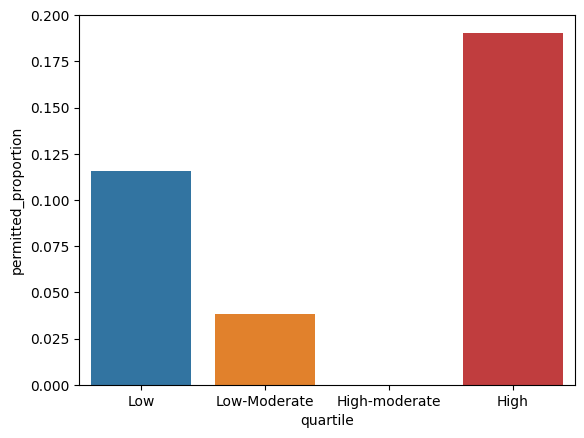

[INFO] Small building construction events across income quartiles


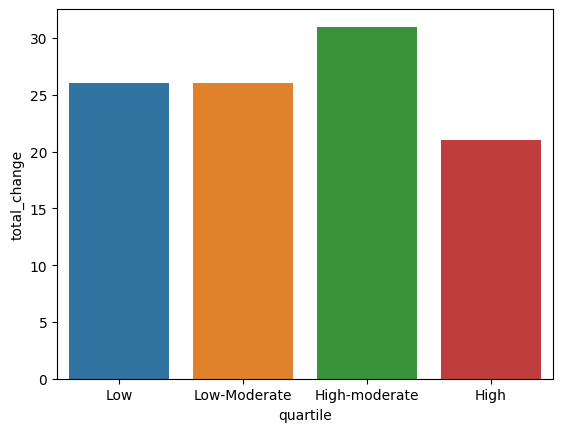


[PIPELINE] Generating PA inputs for SRS.
[INFO] Number of high income CBGS (defined by 75%): 160
[INFO] Distribution of number of construction events across parcels
  neighborhood  expansion_2016_flag   APN
0         high                  0.0  1515
1         high                  1.0    19
2         high                  2.0     1
3          low                  0.0  3928
4          low                  1.0    73
5          low                  2.0     5

[PIPELINE] Generating PA inputs for Neyman allocation.


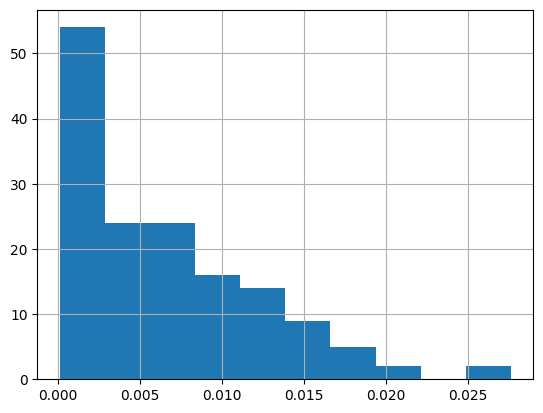

In [15]:
params = {'batch': 1, 'completion': 100, 'min_sqft': 11.1484, 
          'construction_detection': 'CF', 'limit_to_GT': True, 
          'subset': 100, 'verbose': True}

t = main(CF_FP, OAK_FP, OUTPUT_FP, test_cases, permits_2015_20, sj_parcels_cbgs, cbg_income_2016_SJ, params)

# 2. Sensitivity

In [38]:
sample_sizes = range(50, 100, 5)
K = 100

sensitivity_df = pd.DataFrame()
for ss in tqdm(sample_sizes):
    for k in range(K):
        params = {'batch': 1, 'completion': 100, 'min_sqft': 11.1484, 
                  'construction_detection': 'CF', 'limit_to_GT': False, 
                  'subset': ss, 'verbose': False}
        baseline, effect_size = main(CF_FP, OAK_FP, OUTPUT_FP, test_cases, permits_2015_20, sj_parcels_cbgs, cbg_income_2016_SJ, params)
        
        experiment_dict = {'ss': [ss], 'k': [k], 'baseline': [baseline], 'effect_size': [effect_size]}
        sensitivity_df = pd.concat([sensitivity_df, pd.DataFrame.from_dict(experiment_dict)])

sensitivity_df.to_csv(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
            'sensitivity-{}-min{}-GT{}.csv'.format(
                params['construction_detection'], int(params['min_sqft']), 
                1 if params['limit_to_GT'] else 0
            )), index=False)

100%|██████████| 10/10 [18:35<00:00, 111.51s/it]


In [45]:
params = {'batch': 1, 'completion': 100, 'min_sqft': 11.1484, 
                  'construction_detection': 'CF', 'limit_to_GT': False, }

sensitivity_df = pd.read_csv(
            os.path.join(OUTPUT_FP, 'Outcomes', 'B{}-{}'.format(params['batch'], params['completion']), 
            'sensitivity-{}-min{}-GT{}.csv'.format(
                params['construction_detection'], int(params['min_sqft']), 
                1 if params['limit_to_GT'] else 0)))

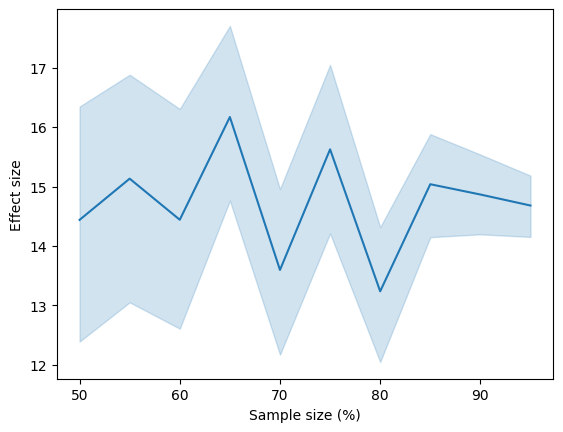

In [46]:
# Plot
ax = sns.lineplot(data=sensitivity_df, x='ss', y='effect_size')
ax.set(xlabel='Sample size (%)', ylabel='Effect size')
plt.show()

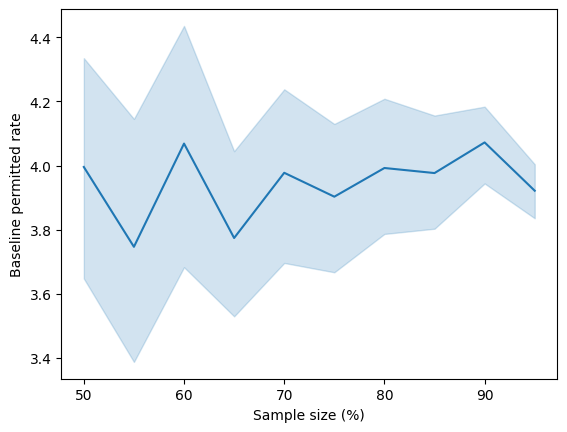

In [47]:
# Plot
ax = sns.lineplot(data=sensitivity_df, x='ss', y='baseline')
ax.set(xlabel='Sample size (%)', ylabel='Baseline permitted rate')
plt.show()